<a href="https://colab.research.google.com/github/ally6606/Computer-Vision-Project/blob/main/ComputerVisionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> <b> Object Detection Using YOLO <b> </h1></center>

This tutorial is designed to provide a comprehensive understanding of how to use YOLO, a state-of-the-art method in computer vision, for detecting objects in images.

Object detection and classification is a key technology in many areas, such as automated vehicles, security, and even healthcare.

We will begin with the basics of preparing (pre processing) an image dataset, ensuring it is ready for effective model training.We will then explore how YOLO, a type of convolutional neural network, automatically extracts features from images to recognize different objects. Understanding this process is crucial for grasping how YOLO operates.

The core of this tutorial is focused on transfer learning using YOLO. We will teach you how to take a pre-trained YOLO model and adapt it to a new dataset. This technique is efficient and powerful, allowing us to harness the strengths of YOLO with less computational effort.

By the end of this tutorial, you will have hands-on experience with preparing data, implementing YOLO, and understanding the principles behind it. This tutorial aims to equip students with practical skills and knowledge in one of the most exciting fields in technology.

Since its inception, the YOLO family of object detection models has come a long way. YOLOv8 is the most recent addition to this famous anchor-based single-shot family of object detectors. It comes with a bunch of improvements which include state-of-the-art accuracy and speed.  In this article, we will be fine tuning the YOLOv8 object detection model on a real-world pothole detection dataset.

In the previous lecture, you were asked to make your own custom datasets for a project you want to work on. Today we will explore how to finetune YOLO on a certain dataset.  

Importing required Libraries

In [ ]:
!pip install tensorflow

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil


[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Dataset Description






Fruit Images for Object Detection

available on kaggle => https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection


- 240 images in train folder. 60 images in test folder.

- 3 different fruits:

    - Apple

    - Banana

    - Orange

The labels are in xml format, which is Extensible markup language.Storing image dataset labels in XML format is quite common. XML provides a clear, hierarchical structure which is ideal for representing the complex data associated with image labels. This includes not just the class of the object, but potentially a wealth of other information like bounding box coordinates, object IDs, and additional metadata.


# Data Preprocessing

For preprocessing:
- We have to convert the dataset into that acceptable by YOLO.
  - Heirarchy of folders should be the one accepted by YOLO
  - Labels format should be darknet YOLO.
  - Labels files should be .txt files
- Check and see if there are any missing labels or images. And remove them from dataset.


## Heirarchy of Folders correction

Defining paths to train and test folders.

In [ ]:
test_dir = '/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/test_zip/test'
train_dir = '/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/train_zip/train'



The train and test folders have all the images and labels together.

But for YOLO, the directories should be in:

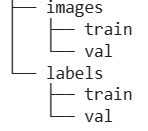


Making directories according to above struture of folders

In [ ]:
#import os
#run it once for making directories

#os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data')
os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data/images')
os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data/labels')
os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data/images/train')
os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data/images/val')
os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data/labels/train')
os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data/labels/val')

In [ ]:
#set the paths to labels and images directory
label_dir= "/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data/labels"
image_dir="/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data/images"

Copy XML files and jpg files from the train folder to the folders created.

In [ ]:
#import shutil
#run it once for copying!
for file in os.listdir(train_dir):
    if file.endswith(".xml"):
        shutil.copy(os.path.join(train_dir, file), os.path.join(label_dir, "train"))
    if file.endswith(".jpg"):
        image = Image.open(os.path.join(train_dir, file))
        image = image.convert("RGB")
        new_filename = os.path.splitext(file)[0] + ".jpg"
        image.save(os.path.join(image_dir,"train", new_filename), "JPEG")
        #shutil.copy(os.path.join(train_dir, file), os.path.join(image_dir, "train"))


#Copy XML files and jpg files from the test folder to the folders created.
for file in os.listdir(test_dir):
    if file.endswith(".xml"):
        shutil.copy(os.path.join(test_dir, file), os.path.join(label_dir, "val"))
    if file.endswith(".jpg"):
        image = Image.open(os.path.join(test_dir, file))
        image = image.convert("RGB")
        new_filename = os.path.splitext(file)[0] + ".jpg"
        image.save(os.path.join(image_dir,"val", new_filename), "JPEG")
        #shutil.copy(os.path.join(test_dir, file), os.path.join(image_dir, "val"))


Visualizing somme pictures from the dataset

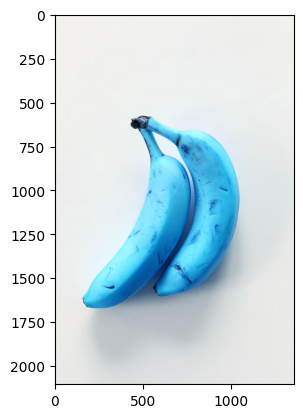

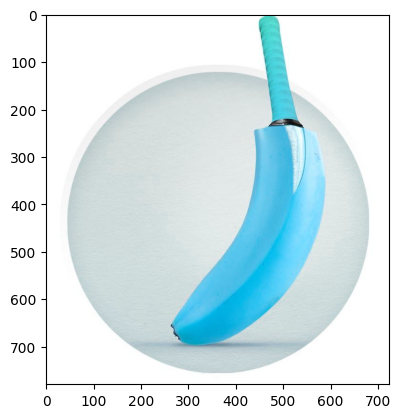

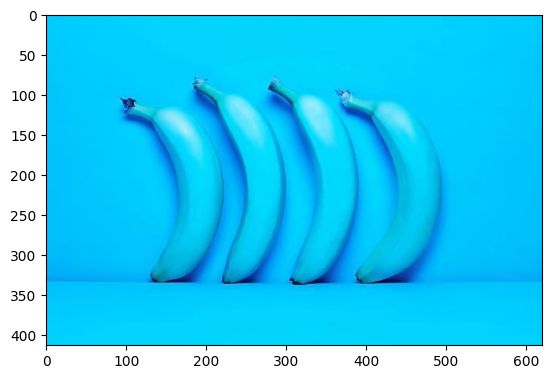

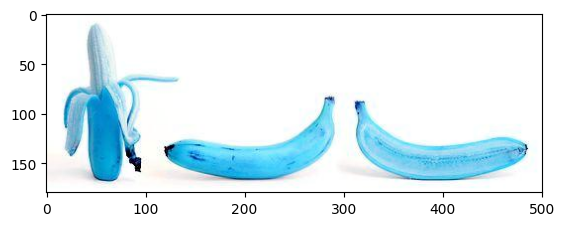

In [ ]:
#visualize first four sample images from train data
for idx, image in enumerate(os.listdir(os.path.join(image_dir, "train"))):
    img = cv2.imread(os.path.join(image_dir,"train", image), 1)
    plt.imshow(img)
    plt.show()

    if idx == 3:
        break

## Creating Text files for labels
Creating Dataframes from .xml files, from which we will eventually create .txt file for each image


In [ ]:
#import glob
#import xml.etree.ElementTree as ET

df = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}


#This is the way to handle xml format files which are in heirarchial form (trees).

for idx, anno in enumerate(glob.glob(label_dir+"/train" + '/*.xml')):

    trees = ET.parse(anno)

    print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        print(item)

        if item.tag == 'size':
            for attr in list(item):
                if attr.tag == 'width':
                    width =int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))

        if item.tag == 'object':
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df['label'] += [label]
                    df['width'] += [width]
                    df['height'] += [height]
                    df['name'] += [anno.split('/')[-1][0:-4]]

                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df['xmin'] += [xmin]

                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df['ymax'] += [ymax]

Streaming output truncated to the last 5000 lines.
<Element 'xmin' at 0x78484e292160>
<Element 'ymin' at 0x78484e292660>
<Element 'xmax' at 0x78484e292b10>
<Element 'ymax' at 0x78484e292200>
/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data/labels/train/apple_14.xml
<Element 'annotation' at 0x78484e27ce00>
<Element 'folder' at 0x78484e27cef0>
<Element 'filename' at 0x78484e2931f0>
<Element 'path' at 0x78484e293a10>
<Element 'source' at 0x78484e2932e0>
<Element 'database' at 0x78484e2933d0>
<Element 'size' at 0x78484e292930>
<Element 'width' at 0x78484e292980>
<Element 'height' at 0x78484e2923e0>
<Element 'depth' at 0x78484e293380>
<Element 'segmented' at 0x78484e291f80>
<Element 'object' at 0x78484e2934c0>
<Element 'name' at 0x78484e292a20>
<Element 'pose' at 0x78484e2924d0>
<Element 'truncated' at 0x78484e293d30>
<Element 'difficult' at 0x78484e292de0>
<Element 'bndbox' at 0x78484e292750>
<Element 'xmin' at 0x78484e292840>
<Element 'ymin' at 0x78484e2928e0>
<Element 'xma

Doing the same for validation data labels.


In [ ]:
#import glob
#import xml.etree.ElementTree as ET

df2 = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}


#This is the way to handle xml format files which are in heirarchial form (tees).

for idx, anno in enumerate(glob.glob(label_dir+"/val" + '/*.xml')):

    trees = ET.parse(anno)

    #print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        #print(item)

        if item.tag == 'size':
            for attr in list(item):
                if attr.tag == 'width':
                    width =int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))

        if item.tag == 'object':
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df2['label'] += [label]
                    df2['width'] += [width]
                    df2['height'] += [height]
                    #dataset['name']+=[anno.split('/')[-1][0:-4]]
                    df2['name'] += [anno.split('/')[-1][0:-4]]

                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df2['xmin'] += [xmin]

                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df2['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df2['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df2['ymax'] += [ymax]

In [ ]:
import pandas as pd
train_df = pd.DataFrame(df)
val_df=pd.DataFrame(df2)
#df1.head()
val_df.head()

,name,label,width,height,xmin,ymin,xmax,ymax
0,apple_77,apple,300,229,71,60,175,164
1,apple_77,apple,300,229,12,22,105,111
2,apple_77,apple,300,229,134,23,243,115
3,apple_77,apple,300,229,107,126,216,229
4,apple_77,apple,300,229,207,138,298,229


Visualizing one of the image in train set with the bounding box

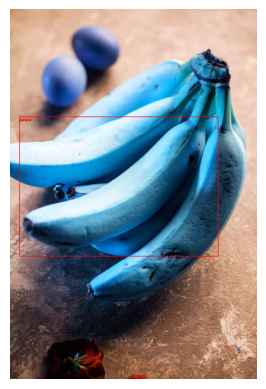

In [ ]:
index= 10 #picture to visualize

#import cv2
image = cv2.imread(os.path.join(image_dir,"train", train_df["name"][index]+".jpg"), 1)
# Draw rectangle
cv2.rectangle(image, (train_df['xmin'][index], train_df['ymin'][index]), (train_df['xmax'][index], train_df['ymax'][index]), (255, 0, 0), 2)
# Put label (class_id) near the bbox
label = train_df["label"][index]
cv2.putText(image, str(label), (train_df['xmin'][index], train_df['ymin'][index]+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
# Display image
plt.imshow(image)
plt.axis('off')
plt.show()

Checking to see if the above image has bounding boxes around other apples or not.

In [ ]:
train_df["name"][index]
filtered_df = train_df[train_df['name'] == train_df["name"][index]]
print(filtered_df)

        name   label  width  height  xmin  ymin  xmax  ymax
9   banana_5  banana   1200    1800   366   575  1173  1514
10  banana_5  banana   1200    1800    46   524  1011  1202
11  banana_5  banana   1200    1800     1   399   899   889
12  banana_5  banana   1200    1800   164   212   945   791


Checking to see the datatypes of all the columns and if there is any null value that needs to be eliminated from the data.

In [ ]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    117 non-null    object
 1   label   117 non-null    object
 2   width   117 non-null    int64 
 3   height  117 non-null    int64 
 4   xmin    117 non-null    int64 
 5   ymin    117 non-null    int64 
 6   xmax    117 non-null    int64 
 7   ymax    117 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 7.4+ KB


What different types of labels are assigned to each sample and checking if they match the provided label/class information, i.e. there are no extra labels due to mistakes in spellings etc.

In [ ]:
print(train_df['label'].unique())
print(val_df['label'].unique())

['banana' 'orange' 'apple']
['apple' 'banana' 'orange']


We need to map labels to class_ids required for YOLO

In [ ]:
label_map = { 'orange': 0,
            'apple': 1,
            'banana': 2}

train_df['class'] = train_df['label'].map(label_map)
val_df['class'] = val_df['label'].map(label_map)

In [ ]:
train_df.head()

,name,label,width,height,xmin,ymin,xmax,ymax,class
0,banana_54,banana,1024,768,77,230,841,572,2
1,banana_54,banana,1024,768,363,211,1013,754,2
2,banana_54,banana,1024,768,37,187,793,485,2
3,banana_53,banana,0,0,4,92,409,434,2
4,banana_52,banana,501,180,117,82,302,174,2


convertig the bounding box format to the one required by YOLO:




In [ ]:
# Training data
train_df['x_center'] = (train_df['xmin']+train_df['xmax'])/(2*train_df["width"])
train_df['y_center'] = (train_df['ymin']+train_df['ymax'])/(2*train_df["height"])
train_df['box_width'] = (train_df['xmax']-train_df['xmin'])/ train_df["width"]
train_df['box_height'] = (train_df['ymax']-train_df['ymin'])/train_df["height"]

#Validation data
val_df['x_center'] = (val_df['xmin']+val_df['xmax'])/(2*val_df["width"])
val_df['y_center'] = (val_df['ymin']+val_df['ymax'])/(2*val_df["height"])
val_df['box_width'] = (val_df['xmax']-val_df['xmin'])/ val_df["width"]
val_df['box_height'] = (val_df['ymax']-val_df['ymin'])/val_df["height"]

In [ ]:
train_df.head()

,name,label,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_width,box_height
0,banana_54,banana,1024,768,77,230,841,572,2,0.448242,0.522135,0.746094,0.445312
1,banana_54,banana,1024,768,363,211,1013,754,2,0.671875,0.628255,0.634766,0.707031
2,banana_54,banana,1024,768,37,187,793,485,2,0.405273,0.437500,0.738281,0.388021
3,banana_53,banana,0,0,4,92,409,434,2,inf,inf,inf,inf
4,banana_52,banana,501,180,117,82,302,174,2,0.418164,0.711111,0.369261,0.511111


Deleting all the sample with Nan values in training and validation data

In [ ]:
#training
print("before deleting (train data): " , train_df.shape)
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("after deleting(train_data): " ,train_df.shape)

#validation
print("before deleting (val data): " , val_df.shape)
val_df.replace([np.inf, -np.inf], np.nan, inplace=True)
val_df.dropna(inplace=True)
print("after deleting(val data): " , val_df.shape)



before deleting (train data):  (465, 13)
after deleting(train_data):  (420, 13)
before deleting (val data):  (117, 13)
after deleting(val data):  (110, 13)


converting the dataframe to type *str* (string) to be stored in text files.

In [ ]:
train_df = train_df.astype(str)
val_df = val_df.astype(str)

If there are more than one bounding boxes in single image, they should be written in one text file. As, you can see in the below example that one image has so many bounding boxes.

In [ ]:
filtered_df = train_df[train_df['name'] == train_df["name"][100]]
(filtered_df.head(15))

,name,label,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_width,box_height
97,apple_65,apple,800,600,70,25,290,226,1,0.225,0.20916666666666667,0.275,0.335
98,apple_65,apple,800,600,35,217,253,453,1,0.18,0.5583333333333333,0.2725,0.3933333333333333
99,apple_65,apple,800,600,183,177,382,411,1,0.353125,0.49,0.24875,0.39
100,apple_65,apple,800,600,605,298,787,513,1,0.87,0.6758333333333333,0.2275,0.35833333333333334
101,apple_65,apple,800,600,498,370,675,567,1,0.733125,0.7808333333333334,0.22125,0.3283333333333333
102,apple_65,apple,800,600,333,239,574,463,1,0.566875,0.585,0.30125,0.37333333333333335
103,apple_65,apple,800,600,191,350,373,543,1,0.3525,0.7441666666666666,0.2275,0.32166666666666666
104,apple_65,apple,800,600,443,425,655,598,1,0.68625,0.8525,0.265,0.28833333333333333


In [ ]:
#file_name = [x.split('.')[0] for x in df1["name"]]

#TRAINING DATA
#finding all the unique names:
unique_names= train_df['name'].unique()

#for each unique name, containing multiple bboxes, combine them together.
for name in unique_names:
  data = train_df[train_df.name == name]
  box_list = []
  for idx in range(len(data)):
        row = data.iloc[idx]
        box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])

#writing on text files
  text = "\n".join(box_list)
  with open(f'{label_dir}/train/{name}.txt', 'w') as file:
            file.write(text)
#############################################################################################
#VALIDATION DATA
#finding all the unique names:
unique_names= val_df['name'].unique()

#for each unique name, containing multiple bboxes, combine them together.
for name in unique_names:
  data = val_df[val_df.name == name]
  box_list = []
  for idx in range(len(data)):
        row = data.iloc[idx]
        box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])

#writing on text files
  text = "\n".join(box_list)
  with open(f'{label_dir}/val/{name}.txt', 'w') as file:
            file.write(text)

## Checking Missing Files

Checking the folders if every image file has a corresponding label file


(We will copy the code, we already used in previous turorial after updating)

In [ ]:
from pathlib import Path

DATA_DIR = Path(r"C:\Users\User\Desktop\Mushrooms-yolov5.v1i.yolov8")  # change to your path

assert (DATA_DIR / "train/images").exists(), "train/images not found"
assert (DATA_DIR / "train/labels").exists(), "train/labels not found"
assert (DATA_DIR / "valid/images").exists(),   "valid/images not found"
assert (DATA_DIR / "valid/labels").exists(),   "valid/labels not found"
# test is optional but recommended:
if not (DATA_DIR / "test/images").exists():
    print("Note: test/ missing — validation will still work.")

In [ ]:
image_dir_val = DATA_DIR / "valid/images"
label_dir_val = DATA_DIR / "valid/labels"

# Gather image and label files
image_files_val = list(image_dir_val.glob("*.*"))
label_files_val = list(label_dir_val.glob("*.txt"))

# Extract stem names (file name without extension)
image_stems = {img.stem for img in image_files_val}
label_stems = {lbl.stem for lbl in label_files_val}

# Find mismatches
missing_labels = image_stems - label_stems
missing_images = label_stems - image_stems

print(f"Validation set:")
print(len(image_files_val), "images  =", len(label_files_val), "labels")
print(f"Missing label files: {len(missing_labels)}")
print(f"Missing image files: {len(missing_images)}")

if missing_labels:
    print("  Example missing label(s):", list(missing_labels)[:5])
if missing_images:
    print("  Example missing image(s):", list(missing_images)[:5])

Validation set:
798 images  = 798 labels
Missing label files: 0
Missing image files: 0


In [ ]:
# Find extra files in each folder

image_files_train = {p.stem for p in (DATA_DIR / "train/images").glob("*.*")}
label_files_train = {p.stem for p in (DATA_DIR / "train/labels").glob("*.txt")}

#TRAINING DATA
extra_images_train = image_files_train - label_files_train
extra_labels_train = label_files_train - image_files_train

# Output the results
print(f"Training Extra images (without corresponding labels): {extra_images_train}")
print(f"Training Extra labels (without corresponding images): {extra_labels_train}")

#VALIDATION DATA
image_files_val = {p.stem for p in (DATA_DIR / "val/images").glob("*.*")}
label_files_val = {p.stem for p in (DATA_DIR / "val/labels").glob("*.txt")}

extra_images_val = image_files_val - label_files_val
extra_labels_val = label_files_val - image_files_val

# Output the results
print(f"Validation Extra images (without corresponding labels): {extra_images_val}")
print(f"Validation Extra labels (without corresponding images): {extra_labels_val}")

Training Extra images (without corresponding labels): set()
Training Extra labels (without corresponding images): set()
Validation Extra images (without corresponding labels): set()
Validation Extra labels (without corresponding images): set()


Make sure that the above info is correct by chceking the data manually.

Now removing from the dataset:

In [ ]:
for file in extra_images_train:
     os.remove(os.path.join(image_dir, "train", file + '.jpg')) # or '.png' depending on your image format

for file in extra_images_val:
     os.remove(os.path.join(image_dir, "val", file + '.jpg'))

Now run the above cells again to find if all the missing data is deleted.

# Custom object detection using YOLO

First install and import

In [1]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.221 🚀 Python-3.13.7 torch-2.9.0 CPU (Apple M2)
Setup complete ✅ (8 CPUs, 8.0 GB RAM, 388.2/460.4 GB disk)


In [2]:
from ultralytics import YOLO

In [3]:
import sys, platform, torch, os, subprocess

print("Python exe:", sys.executable)
print("Python ver:", sys.version)
print("Platform:", platform.platform())
print("CUDA seen by torch BEFORE reinstall:", torch.cuda.is_available() if 'torch' in globals() else 'torch not imported')


Python exe: /Library/Frameworks/Python.framework/Versions/3.13/bin/python3.13
Python ver: 3.13.7 (v3.13.7:bcee1c32211, Aug 14 2025, 19:10:51) [Clang 16.0.0 (clang-1600.0.26.6)]
Platform: macOS-12.5-arm64-arm-64bit-Mach-O
CUDA seen by torch BEFORE reinstall: False


## Training YOLO

We are going to select small pretrained (on COCO dataset) model of YOLOv8

In [4]:
model = YOLO('yolov8s.pt') # pretrained model

The detailed architecture of the model can be seen from:


In [5]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [6]:
%%writefile config.yaml
path: /Users/allycui/Desktop/SFU Fall2025/IAT 360/Group_Assignment1

train: /Users/allycui/Desktop/SFU Fall2025/IAT 360/Group_Assignment1/train/images
val: /Users/allycui/Desktop/SFU Fall2025/IAT 360/Group_Assignment1/valid/images
test: /Users/allycui/Desktop/SFU Fall2025/IAT 360/Group_Assignment1/test/images

# Classes
nc: 21 # replace based on your dataset's number of classes

# Class names
# replace all class names with your own classes' names
names: [
  'Agaricus bisporus',
  'Agaricus blazei Murill',
  'Agrocybe aegerita',
  'Armillaria mellea',
  'Auricularia auricula',
  'Boletus',
  'Cantharellus cibarius',
  'Clitocybe maxima',
  'Collybia albuminosa',
  'Coprinus comatus',
  'Cordyceps militaris',
  'Dictyophora indusiate',
  'Flammulina velutiper',
  'Hericium erinaceus',
  'Hypsizygus marmoreus',
  'Lentinus edodes',
  'Morchella esculenta',
  'Pleurotus citrinopileatus',
  'Pleurotus cystidiosus',
  'Pleurotus eryngii',
  'Pleurotus ostreatus'
]

Overwriting config.yaml


Please look at [Yolo train Docs](https://docs.ultralytics.com/modes/train/#train-settings) for hyperparameters for model tuning and configuration, e.g. lr0, imgsz, model etc.

In [ ]:
model.train(data="config.yaml",epochs=15,patience=5,batch=16, lr0=0.001,imgsz=640)

Ultralytics 8.3.218  Python-3.11.0 torch-2.10.0.dev20251021+cu128 CUDA:0 (NVIDIA GeForce RTX 5070 Ti, 16303MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=config.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train19, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000022E9995DE50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
       0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
       0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
       0.04004004, 0.04104104,

## Evaluation Metrics

[This](https://docs.ultralytics.com/guides/yolo-performance-metrics/) is a very good detailed explanation of different perfromance metrics in YOLO.

**Choosing the Right Metrics**

Choosing the right metrics to evaluate often depends on the specific application.

- mAP: Suitable for a broad assessment of model performance.

- IoU: Essential when precise object location is crucial.

- Precision: Important when minimizing false detections is a priority.

- Recall: Vital when it's important to detect every instance of an object.

- F1 Score: Useful when a balance between precision and recall is needed.


In [ ]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category
metrics.box.mp    # P
metrics.box.mr    # R

Ultralytics 8.3.218  Python-3.11.0 torch-2.10.0.dev20251021+cu128 CUDA:0 (NVIDIA GeForce RTX 5070 Ti, 16303MiB)
Model summary (fused): 72 layers, 11,133,711 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 849.3324.8 MB/s, size: 43.6 KB)
val: Scanning C:\Users\User\Desktop\Mushrooms-yolov5.v1i.yolov8\valid\labels.cache... 798 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 798/798  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 10.8it/s 4.6s
                   all        798       1801      0.747      0.684      0.748      0.595
     Agaricus bisporus         32        105       0.78      0.705      0.791      0.674
Agaricus blazei Murill         27         66      0.581      0.485      0.519      0.364
     Agrocybe aegerita         35         43      0.726      0.677      0.642       0.54
     Armillaria mellea         39         70      0.579      0.557      0.637      0.5

np.float64(0.6843447551851147)

Showing confusion matrix, that is already stored in detect/train folder

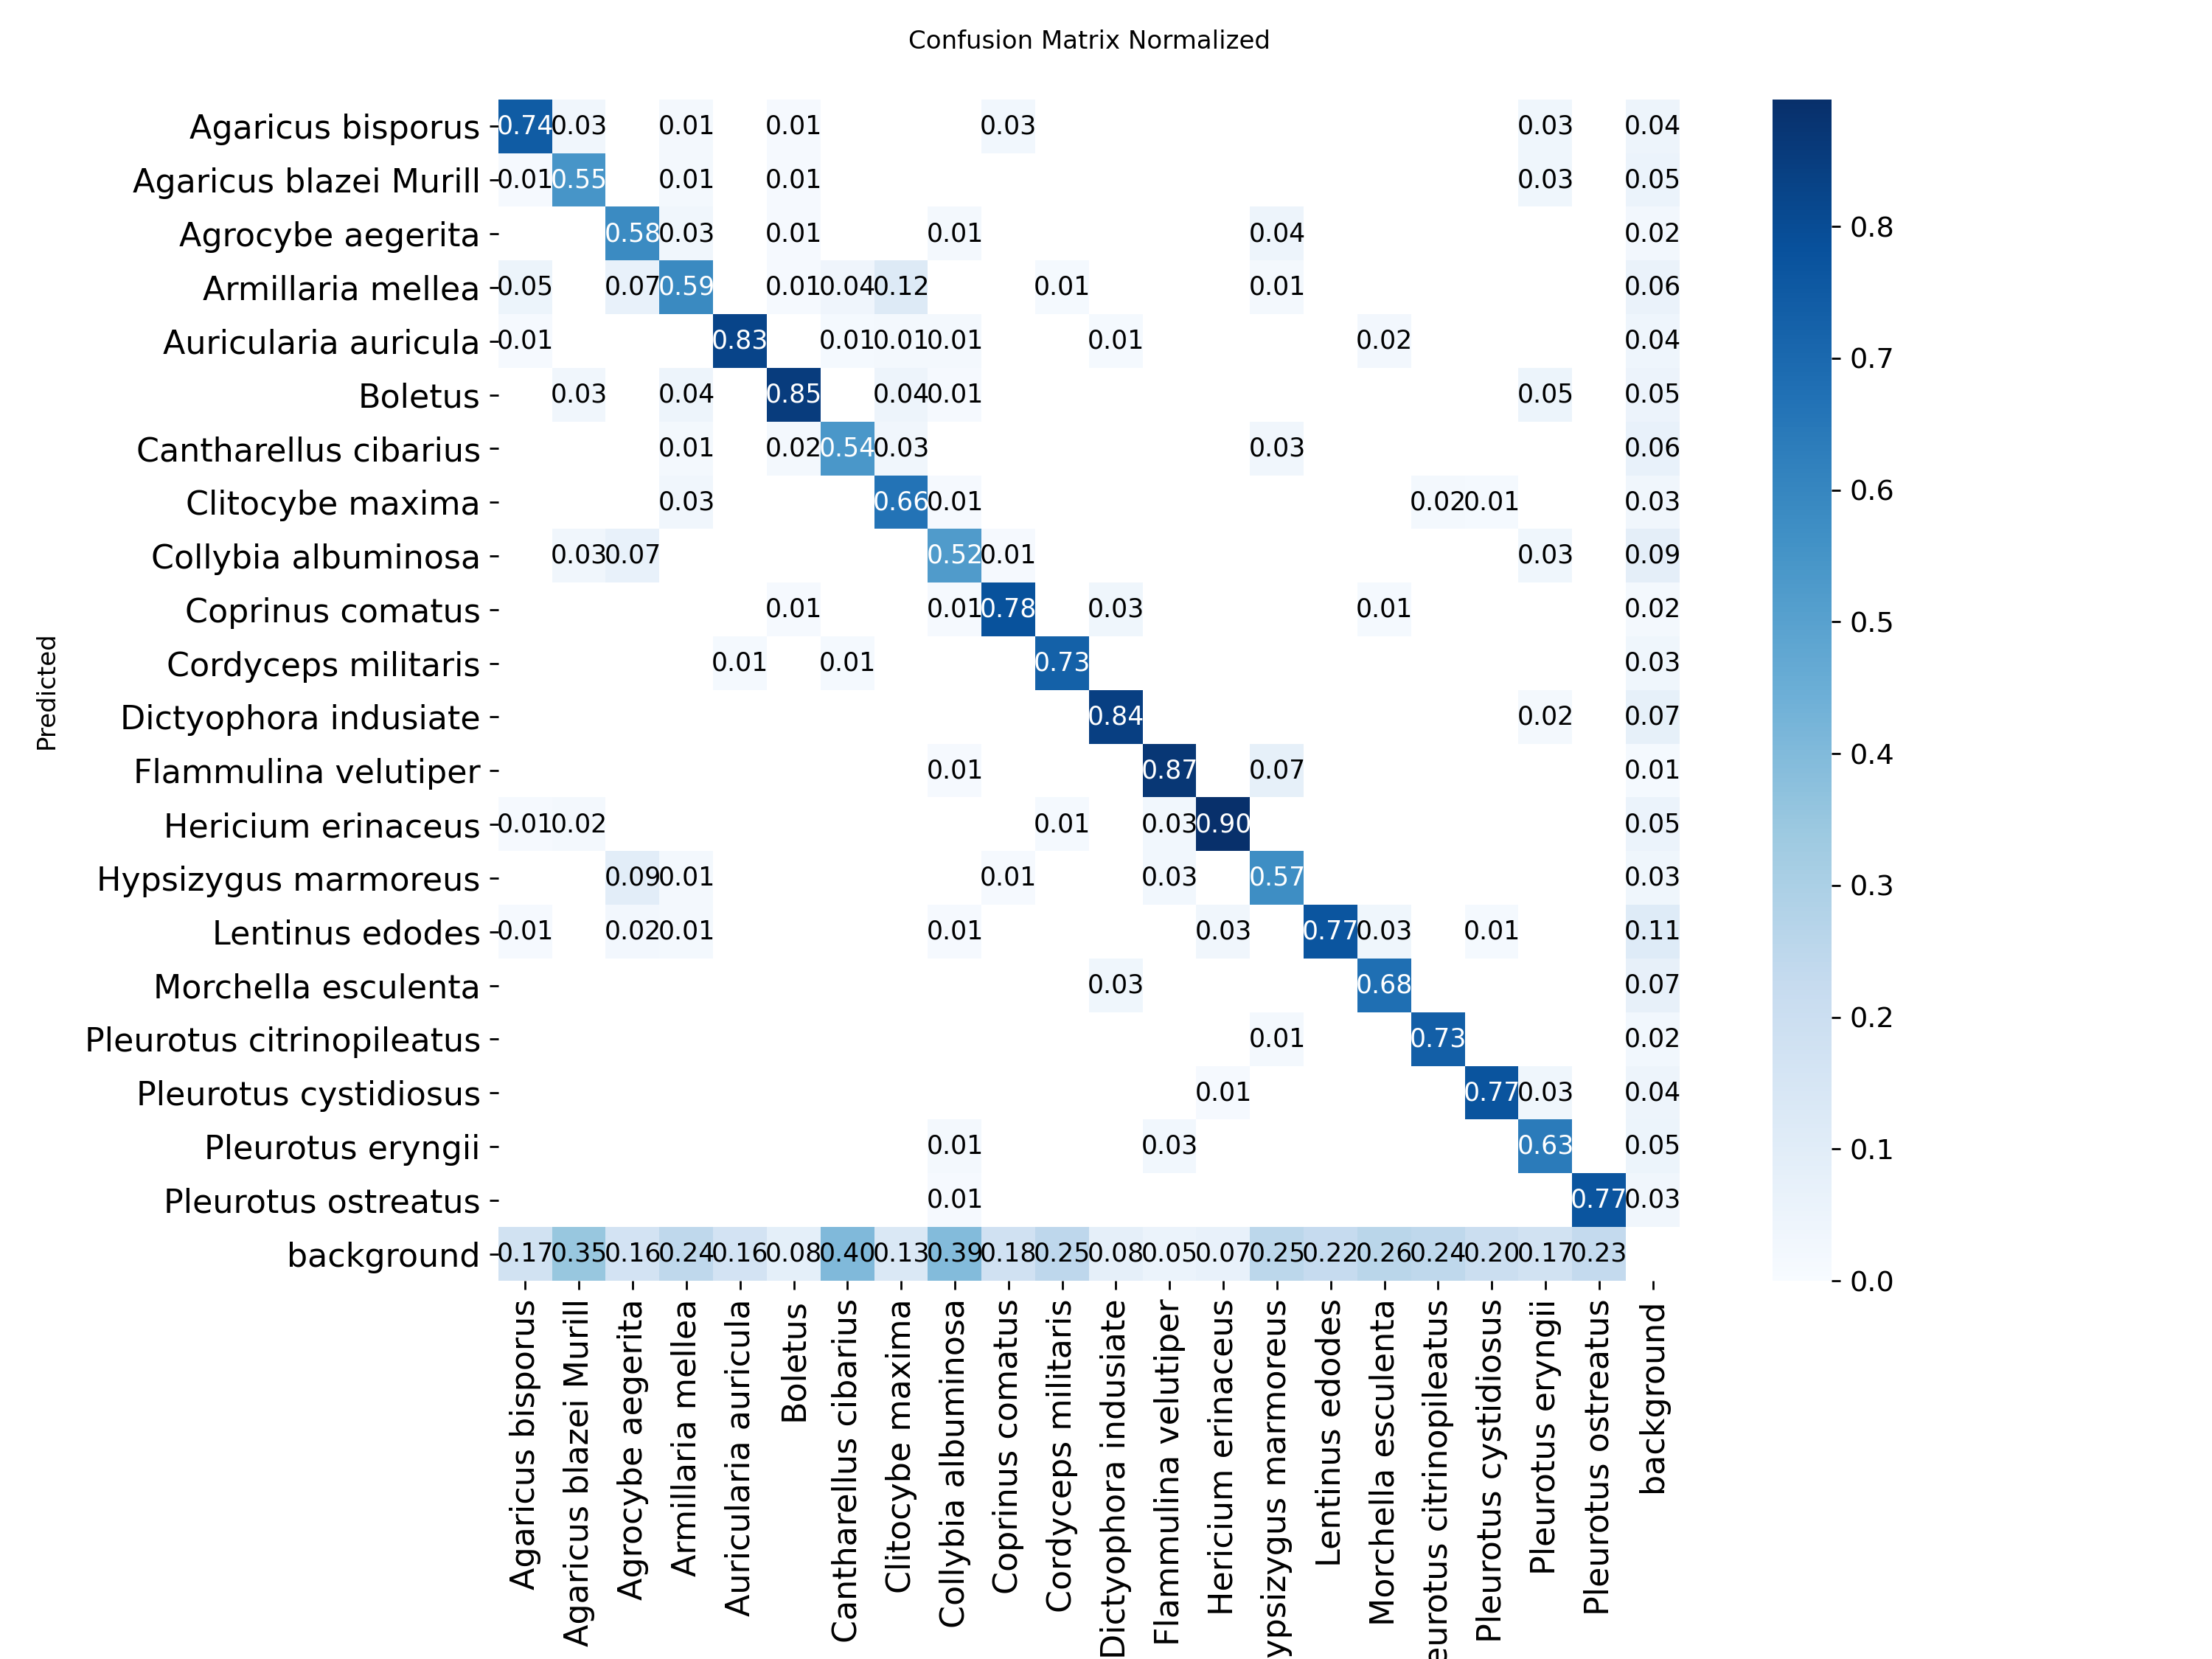

In [ ]:
%matplotlib inline
from PIL import Image

Image.open('C:/Users/User/runs/detect/val4/confusion_matrix_normalized.png')

# Test

In [ ]:
model = YOLO('/Users/allycui/Desktop/SFU Fall2025/IAT 360/Group_Assignment1/best.pt')

results = model.val(data='config.yaml', split='test')

print(f"mAP50-95: {results.box.map:.3f}")
print(f"mAP50:    {results.box.map50:.3f}")
print(f"Precision:{results.box.mp:.3f}")
print(f"Recall:   {results.box.mr:.3f}")


Ultralytics 8.3.221 🚀 Python-3.13.7 torch-2.9.0 CPU (Apple M2)
Model summary (fused): 72 layers, 11,133,711 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.1 ms, read: 142.7±48.6 MB/s, size: 25.6 KB)
val: Scanning /Users/allycui/Desktop/SFU Fall2025/IAT 360/Group_Assignment1/test/labels.cache... 827 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 827/827 1.5Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 52/52 0.2it/s 4:18
                   all        827       1838      0.716      0.672      0.721      0.576
     Agaricus bisporus         33         79      0.447      0.747      0.678      0.553
Agaricus blazei Murill         28         57      0.612      0.754      0.756      0.603
     Agrocybe aegerita         37         38      0.761      0.868      0.883      0.705
     Armillaria mellea         41         60      0.602      0.567      0.577      0.442
  Auricularia auricula    

# Test(custom60 images)

In [11]:
%%writefile config_custom.yaml
path: /Users/allycui/Desktop/SFU Fall2025/IAT 360/Group_Assignment1

train: /Users/allycui/Desktop/SFU Fall2025/IAT 360/Group_Assignment1/train/images
val: /Users/allycui/Desktop/SFU Fall2025/IAT 360/Group_Assignment1/valid/images
test: /Users/allycui/Desktop/SFU Fall2025/IAT 360/Group_Assignment1/test_customer/images

# Classes
nc: 21 # replace based on your dataset's number of classes

# Class names
# replace all class names with your own classes' names
names: [
  'Agaricus bisporus',
  'Agaricus blazei Murill',
  'Agrocybe aegerita',
  'Armillaria mellea',
  'Auricularia auricula',
  'Boletus',
  'Cantharellus cibarius',
  'Clitocybe maxima',
  'Collybia albuminosa',
  'Coprinus comatus',
  'Cordyceps militaris',
  'Dictyophora indusiate',
  'Flammulina velutiper',
  'Hericium erinaceus',
  'Hypsizygus marmoreus',
  'Lentinus edodes',
  'Morchella esculenta',
  'Pleurotus citrinopileatus',
  'Pleurotus cystidiosus',
  'Pleurotus eryngii',
  'Pleurotus ostreatus'
]

Writing config_custom.yaml


In [14]:
model = YOLO('/Users/allycui/Desktop/SFU Fall2025/IAT 360/Group_Assignment1/best.pt')
results_custom = model.val(data='config_custom.yaml', split='test')

print(f"Custom60 mAP50-95: {results_custom.box.map:.3f}")
print(f"Custom60 mAP50:    {results_custom.box.map50:.3f}")
print(f"Custom60 Precision:{results_custom.box.mp:.3f}")
print(f"Custom60 Recall:   {results_custom.box.mr:.3f}")

Ultralytics 8.3.221 🚀 Python-3.13.7 torch-2.9.0 CPU (Apple M2)
Model summary (fused): 72 layers, 11,133,711 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 263.5±184.2 MB/s, size: 83.0 KB)
val: Scanning /Users/allycui/Desktop/SFU Fall2025/IAT 360/Group_Assignment1/test_customer/labels.cache... 63 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 63/63 165.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 0.2it/s 18.5s
                   all         63        177      0.497      0.263      0.301      0.267
     Agaricus bisporus          6         18      0.804        0.5      0.535      0.524
Agaricus blazei Murill          6         19          1      0.413      0.601      0.551
     Agrocybe aegerita          6         40          0          0     0.0564     0.0376
     Armillaria mellea          6         24          0          0     0.0166     0.0112
  Auricularia auri

##Prediction

In [ ]:
model = YOLO(' )  # load a custom model

# Predict with the model with any image from internet?
results = model('https://www.freshpoint.com/wp-content/uploads/2019/08/freshpoint-produce-101-apples-bananas.jpg', save=True)

100%|██████████| 126k/126k [00:00<00:00, 580kB/s] 


image 1/1 /content/freshpoint-produce-101-apples-bananas.jpg: 576x640 2 apples, 3 bananas, 112.8ms
Speed: 1.8ms preprocess, 112.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 640)
Results saved to runs/detect/predict


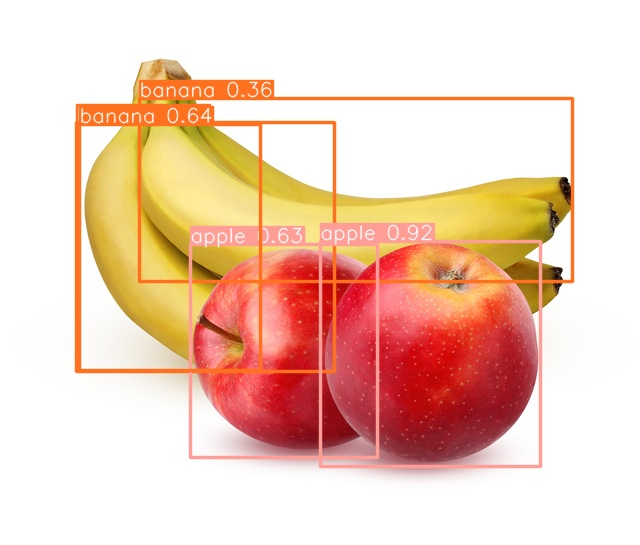

In [ ]:
# SHOW THE IMAGE STORED
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/predict/freshpoint-produce-101-apples-bananas.jpg')